In [4]:
import datetime as dt

dt.datetime.strptime("2013-02-08", "%Y-%m-%d").date() - dt.date(2012, 8, 13)
dt.date(2016,4,9) - dt.date(2013,4,10)

datetime.timedelta(days=1095)

In [1]:
from src.environments.market import Market

m = Market("2013-04-08", "2013-04-10", 3)
m.data.shape

(16, 5, 5)

In [2]:
a,b = m.step()
print(a[0,:,:], a[1,:,:], b)
print(m.next_step, m.step_to_date())

ValueError: not enough values to unpack (expected 4, got 2)

In [1]:
from src.environments.portfolio import Portfolio

p = Portfolio("2013-02-12", "2016-02-05", 3)
p.market.data.shape

[*********************100%***********************]  1 of 1 completed


(16, 754, 5)

<Figure size 432x288 with 0 Axes>

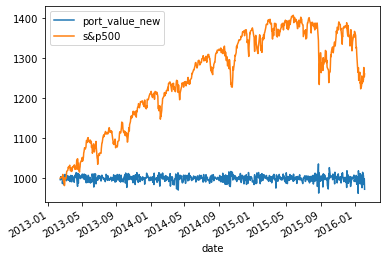

In [2]:
import numpy as np

p.reset()
while True:
    action = np.random.rand(17)
    a,b,c,d = p.step(action)
    if d:
        break

p.render()

In [35]:

import yfinance as yf
import numpy as np
start_date = "2013-02-09"
end_date = "2018-02-08"

snp = yf.download('SPY', start=start_date, end=end_date)
print(snp)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-02-08  151.220001  151.889999  151.220001  151.800003  127.174652   
2013-02-11  151.740005  151.899994  151.389999  151.770004  127.149529   
2013-02-12  151.779999  152.300003  151.610001  152.020004  127.358894   
2013-02-13  152.330002  152.610001  151.720001  152.149994  127.467819   
2013-02-14  151.690002  152.470001  151.520004  152.289993  127.585159   
...                ...         ...         ...         ...         ...   
2018-02-01  281.070007  283.059998  280.679993  281.579987  260.781952   
2018-02-02  280.079987  280.230011  275.410004  275.450012  255.104782   
2018-02-05  273.450012  275.850006  263.309998  263.929993  244.435593   
2018-02-06  259.940002  269.700012  258.700012  269.130005  249.251511   
2018-02-07  268.500000  272.359985  267.579

In [45]:
print(snp.index.astype(str).to_numpy())
print(snp.columns)

['2013-02-08' '2013-02-11' '2013-02-12' ... '2018-02-05' '2018-02-06'
 '2018-02-07']
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


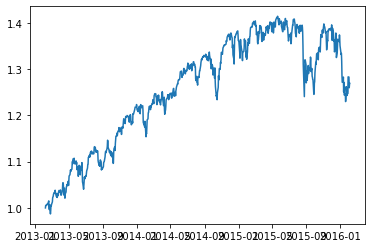

In [25]:
import matplotlib.pyplot as plt
plt.plot(snp['Close'] / snp.iloc[0]['Close'])

In [3]:
from src.environments.market import Market

m = Market("2013-02-12", "2016-02-05", 3)
print(m.snp.shape, m.data.shape)

(754, 5) (16, 754, 5)
